In [5]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import sys
sys.path.append('../../code/scripts')
import utils
import plotting as p
from dataset_params import dataset_params

from importlib import reload

#reload(dataset_params)

Populating the interactive namespace from numpy and matplotlib


/data/erolf/anaconda3/envs/torch_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
with open('../../data/isic/int_metadata/df_with_sonic.json', 'rb') as f:
    metadata = json.load(f)
    
group_id_dict = {}
for key, item in metadata['study_name_to_id'].items():
    group_id_dict[item] = key
    
group_id_dict[0] = '2018 JID Ed.'

sonic_id = metadata['study_name_to_id']['SONIC']

group_names = list(group_id_dict.values())

# 1. read in results

In [7]:
reload(utils)

num_seeds = 10
num_groups = 10

subset_results = utils.read_in_results(group_key='study_name_id',
                               results_type='subset',
                               results_identifier='isic_sonic_leave_one_group_outERM',
                               obj='ERM',
                               sgd_params = {'lr': 0.001, 'weight_decay': 0.001, 'momentum': 0.9},
                               num_seeds = num_seeds,
                               return_preds = True)
        


In [9]:
reload(utils)

num_seeds = 10
num_groups = 10

r_ERM = utils.read_in_results(group_key='study_name_id',
                               results_type='subset',
                               results_identifier='isic_sonic_leave_one_group_outERM',
                               obj='ERM',
                               sgd_params = {'lr': 0.001, 'weight_decay': 0.001, 'momentum': 0.9},
                               num_seeds = num_seeds,
                               return_preds = True)
        
groups, group_sizes, total_accs, group_accs, preds = r_ERM

In [10]:
accs_pct_diffs = {}
accs_abs_diffs = {}
accs_loo = {}
accs_all_data_mean = {}
for acc_key in ['auc_roc', 'acc']:

    accs_by_subset = group_accs[acc_key][:,:num_groups]
    accs_all_data = group_accs[acc_key][:,num_groups]

    mean_accs_loo = accs_by_subset.mean(axis=-1)
    mean_accs_all_data = accs_all_data.mean(axis=1)
    mean_accs_all_data_square = np.array([mean_accs_all_data]*10).T

    acc_abs_diffs = mean_accs_loo - mean_accs_all_data_square
    acc_pct_diffs = (mean_accs_loo - mean_accs_all_data_square) /mean_accs_all_data_square
    
    accs_abs_diffs[acc_key] = acc_abs_diffs
    accs_pct_diffs[acc_key] = acc_pct_diffs
    accs_loo[acc_key] = mean_accs_loo
    accs_all_data_mean[acc_key] = mean_accs_all_data_square

Text(0, 0.5, 'AUROC')

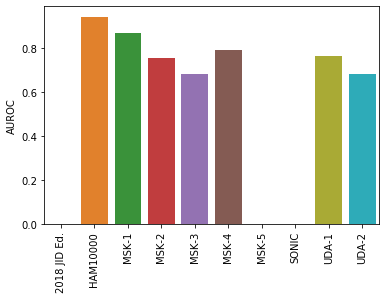

In [11]:
acc_key = 'auc_roc'
ax = sns.barplot(np.arange(num_groups),accs_all_data_mean[acc_key].mean(axis=1))
ax.set_xticklabels(group_names, rotation=90);
ax.set_ylabel('AUROC')

In [12]:
has_auc_mask = ~np.isnan(accs_all_data_mean[acc_key].mean(axis=1))
has_auc_mask

array([False,  True,  True,  True,  True,  True, False, False,  True,
        True])

# plot sorted by pct malignant

In [13]:
p.setup_fonts()

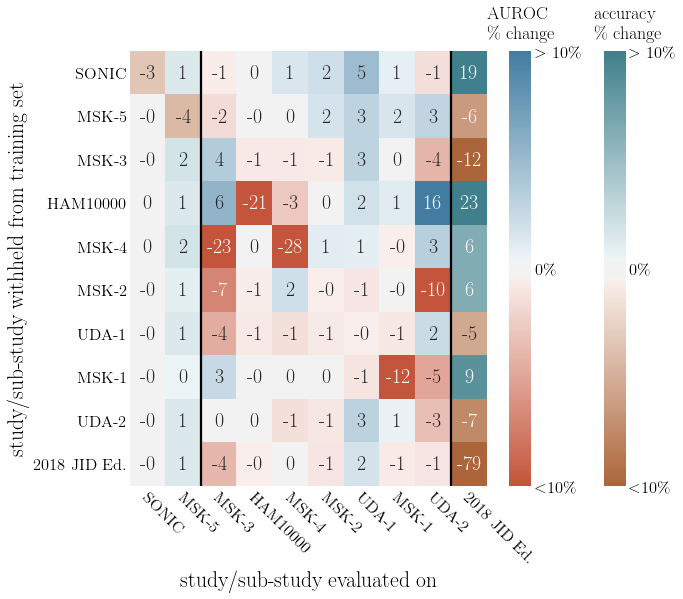

In [23]:
sns.set_context('talk')

cmap_auc = sns.diverging_palette(19,235,s=74, l=50,as_cmap=True)
cmap_acc = sns.diverging_palette(32,210,s=74, l=50,as_cmap=True)

fracs_malignant = preds[0][0].groupby('study_name_id').mean()['label'].values
sort_by_mal = np.argsort(fracs_malignant)
# 0 and 1 are the same - reorder so sonic is first
sort_by_mal2 = sort_by_mal.copy()
sort_by_mal2[0] = sort_by_mal[1]
sort_by_mal2[1] =  sort_by_mal[0]
sort_by_mal = sort_by_mal2

group_sizes[:,-1][sort_by_mal]

groups_by_mal = [group_names[x] for x in sort_by_mal]
has_auc_mask_by_mal = [has_auc_mask[x] for x in sort_by_mal]

fig, ax = plt.subplots(figsize=(10,8))

# plot acc for the groups that don't have AUROC
accs_baseline = accs_pct_diffs['acc'][sort_by_mal][:,sort_by_mal]

accs_baseline[has_auc_mask_by_mal] = np.nan

ax1 = sns.heatmap(accs_baseline.T, cmap=cmap_acc, vmin=-.1, vmax=.1,
                 center=0.00,annot=True, fmt ='.0%', annot_kws={"size":20, "weight": "bold"})

ax2 = sns.heatmap(accs_pct_diffs['auc_roc'][sort_by_mal][:,sort_by_mal].T, cmap=cmap_auc, vmin=-.1, vmax=.1,
                 center=0.00,annot=True, fmt ='.0%', annot_kws={"size":20, "weight": "bold"})


for i in range(2):
    cbar = ax.collections[i].colorbar
    cbar.set_ticks([-.10, 0, .1])
    cbar.set_ticklabels(['$ <$10\%', '0\%', '$>$ 10\%'])
    cbar.ax.tick_params(size=0)
    
    

ax.tick_params(size=0)
    
## c1 = ax1.colorbar
# c1.set_label('acc')
ax.text(10,-.3, 'AUROC \n \% change')
ax.text(13,-.3, 'accuracy \n \% change')

ax.set_xticks(np.arange(len(groups_by_mal))+.25)
ax.set_xticklabels(groups_by_mal, rotation=-45, ha='left')
# ax.set_xticks(np.arange(len(groups_by_mal))+.75)
# ax.set_xticklabels(groups_by_mal, rotation=45, ha='right')
ax.set_yticklabels(groups_by_mal, rotation=0)

plt.axvline(2, color='black')
plt.axvline(9, color='black')

plt.ylabel('study/sub-study withheld from training set', fontsize='large')
plt.xlabel('study/sub-study evaluated on', fontsize='large')

plt.savefig('../../figures/isic_loo_datasets.pdf', bbox_inches='tight')

# get accuracies for SONIC vs the test

In [ ]:
sonic_study_id = metadata['study_name_to_id']['SONIC']

In [ ]:
import sklearn.metrics

aucs_with_all_data = []

for i in range(num_seeds):
    preds_this = preds[i][0]

    preds_sonic = preds_this[preds_this['study_name_id'] ==  metadata['study_name_to_id']['SONIC']]
    preds_not_sonic = preds_this[preds_this['study_name_id'] !=  metadata['study_name_to_id']['SONIC']]

    auc = sklearn.metrics.roc_auc_score(preds_not_sonic['label'], preds_not_sonic['pred'])
    
    aucs_with_all_data.append(auc)

In [ ]:
aucs_without_sonic = []
accs_without_sonic = []

num_seeds = 10
for i in range(num_seeds):

    preds_this = preds[0][sonic_study_id]

    preds_sonic = preds_this[preds_this['study_name_id'] ==  metadata['study_name_to_id']['SONIC']]
    preds_not_sonic = preds_this[preds_this['study_name_id'] !=  metadata['study_name_to_id']['SONIC']]

    auc = sklearn.metrics.roc_auc_score(preds_not_sonic['label'], preds_not_sonic['pred'])
    aucs_without_sonic.append(auc)
    
    acc = sklearn.metrics.accuracy_score(preds_not_sonic['label'], preds_not_sonic['pred'] > 0.5)
    accs_without_sonic.append(acc)

In [ ]:
# simlar to the results for aggregated by study: we report results when aggregated by study in the paper

In [ ]:
print('evaluated on non-SONIC')
print('auc with all data: {0:.3f}'.format(np.mean(aucs_with_all_data)))
print('auc excluding sonic data from the list: {0:.3f}'.format(np.mean(aucs_without_sonic)))


In [ ]:
print('evaluated on all including SONIC')
total_acc_means = total_accs['auc_roc'].mean(axis=1)
print('auc with all data: {0:.3f}'.format(total_acc_means[-1]))
print('auc excluding sonic data from the list: {0:.3f}'.format(total_acc_means[sonic_id]))
